<a href="https://colab.research.google.com/github/mehmetalivarol/veri-analitigi-egitim/blob/master/lstm_time_series_DZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from time import time
from scipy import stats
from statsmodels.tsa.stattools import adfuller

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

pd.set_option('display.float_format', lambda x: '%.4f' % x)
mpl.rcParams['figure.figsize'] = (12, 7)
mpl.rcParams['axes.grid'] = False
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
warnings.filterwarnings('ignore')

In [12]:
df['Units'] = pd.to_numeric(df['Units'], errors='coerce')
df = df.dropna(subset=['Units'])

df=df.loc[:,['date','Units']]
df.sort_values('date', inplace=True, ascending=True)
df = df.reset_index(drop=True)

print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date.min())
print('The time series ends on: ', df.date.max())

Number of rows and columns after removing missing values: (761, 2)
The time series starts from:  2017-07-01 00:00:00
The time series ends on:  2019-07-31 00:00:00


In [13]:
df.head()

,date,Units
0,2017-07-01,67
1,2017-07-02,0
2,2017-07-03,275
3,2017-07-04,183
4,2017-07-05,176


In [14]:
stat, p = stats.normaltest(df.Units)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=36.186, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -0.6616265159455672
Skewness of normal distribution: 0.1899422110534846


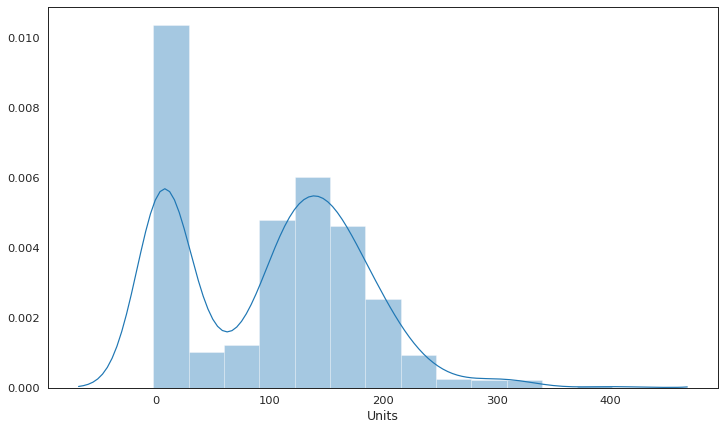

In [15]:
sns.distplot(df.Units);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Units)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Units)))

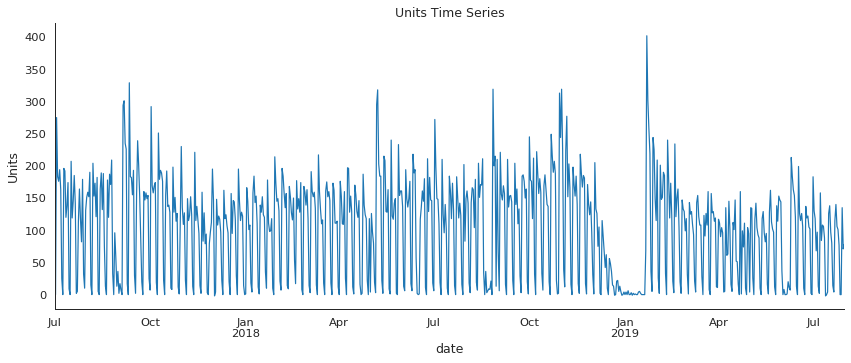

In [16]:
df1=df.loc[:,['date','Units']]
df1.set_index('date',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Units')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Units Time Series')
sns.despine(top=True)
plt.show();

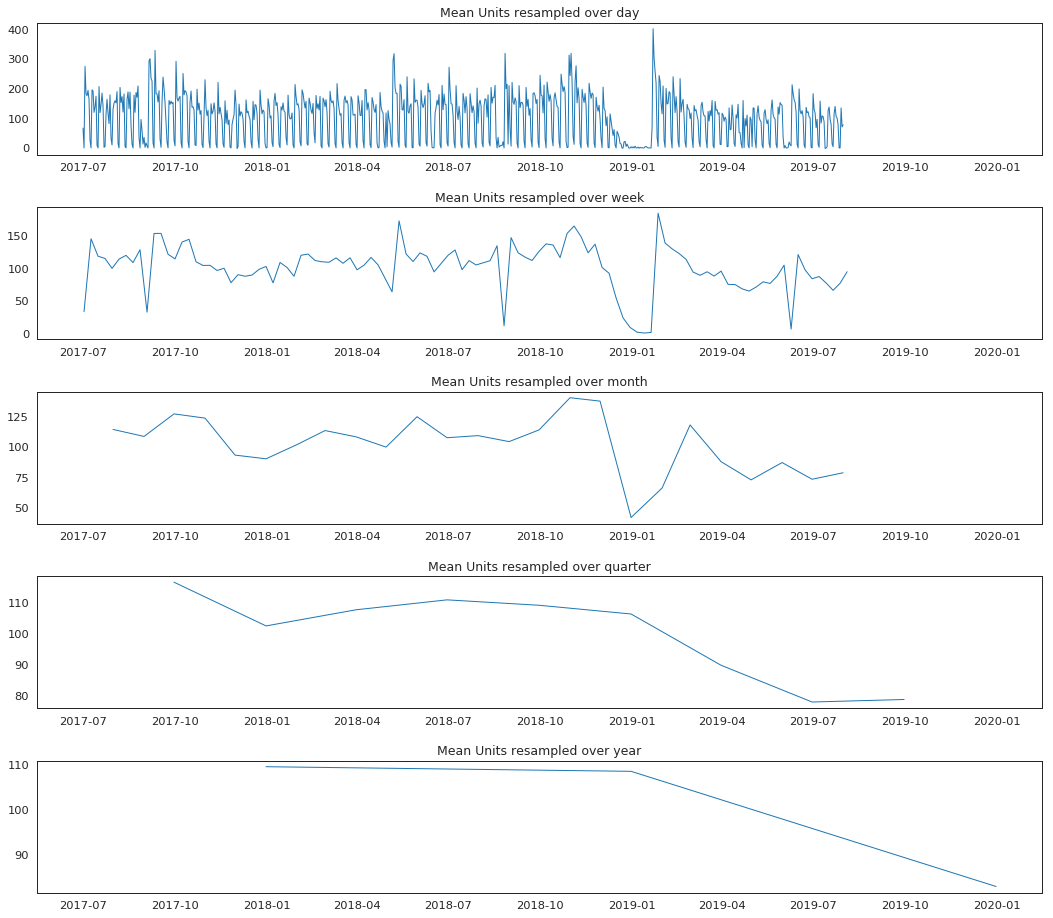

In [0]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Units'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Units resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Units'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Units resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Units'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Units resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Units'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Units resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Units'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Units resampled over year')
ax5.tick_params(axis='both', which='major');

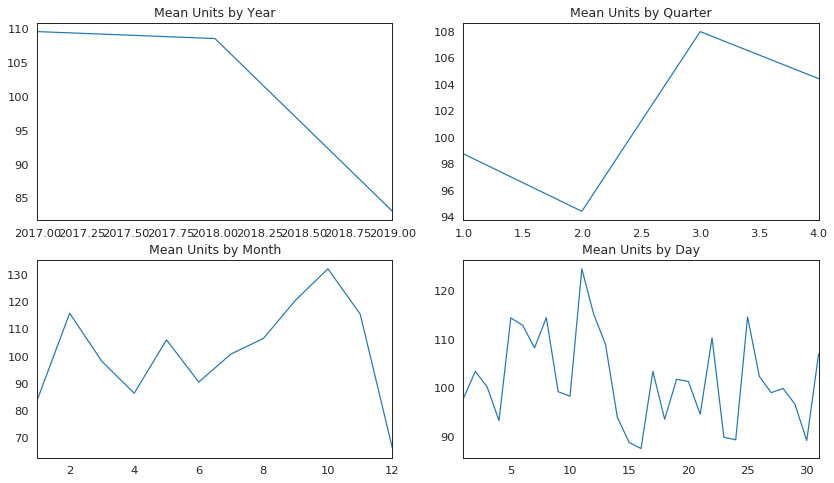

In [0]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('Year').Units.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Units by Year')

plt.subplot(2,2,2)
df.groupby('Quarter').Units.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Units by Quarter')

plt.subplot(2,2,3)
df.groupby('Month').Units.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Units by Month')

plt.subplot(2,2,4)
df.groupby('Day').Units.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Units by Day');

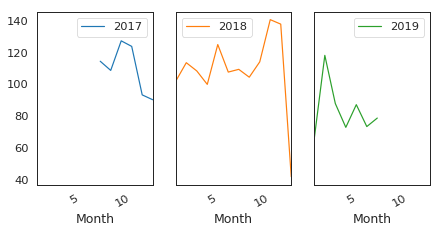

In [0]:
pd.pivot_table(df, values = 'Units',columns = "Year", index = "Month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

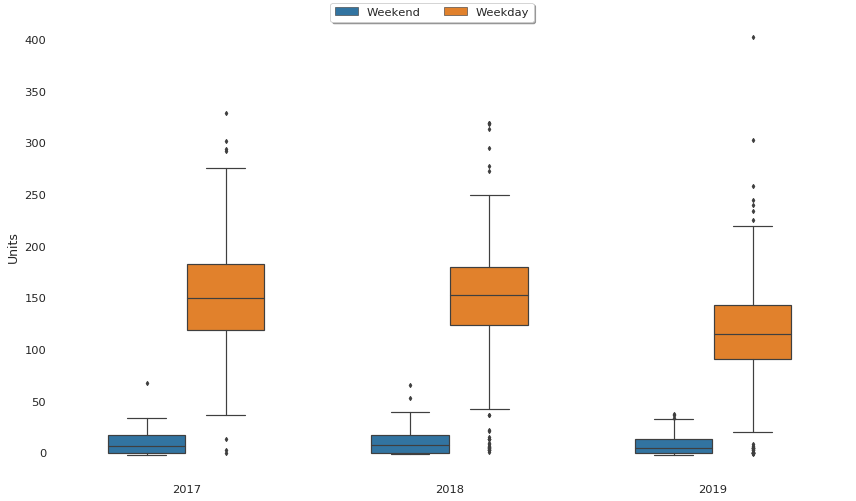

In [0]:
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)
a=plt.figure(figsize=(12,7)) 
plt1=sns.boxplot('Year','Units',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

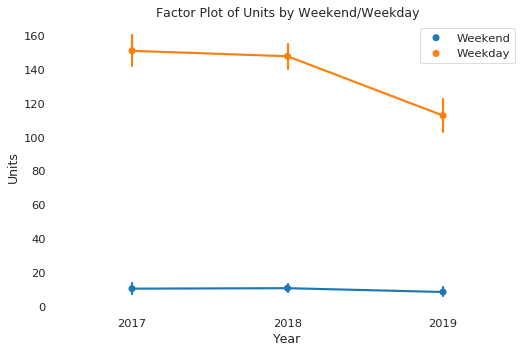

In [0]:
plt1=sns.factorplot('Year','Units',hue='Day',
                    data=df, size=5, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Units by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

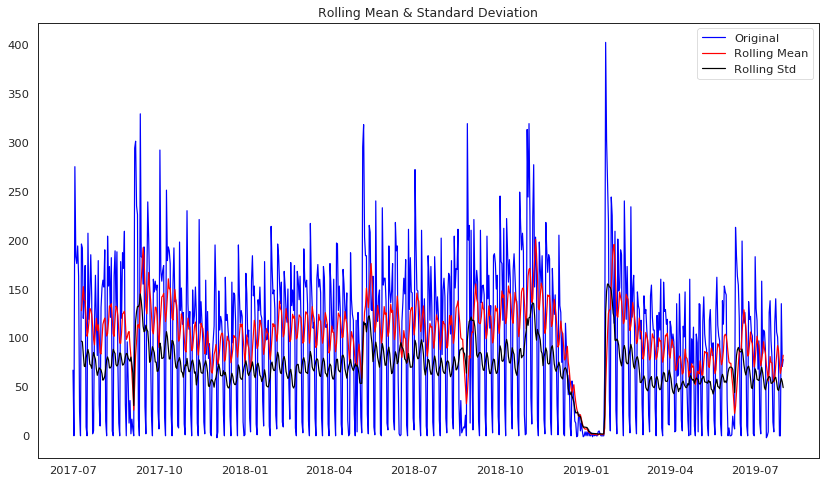

<Results of Dickey-Fuller Test>
Test Statistic                 -3.0706
p-value                         0.0288
#Lags Used                     20.0000
Number of Observations Used   740.0000
Critical Value (1%)            -3.4392
Critical Value (5%)            -2.8655
Critical Value (10%)           -2.5689
dtype: float64


In [0]:
df2=df1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=10).mean()
    rolstd = timeseries.rolling(window=10).std()
    
    plt.figure(figsize=(14,8))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Units.dropna())

NameError: ignored

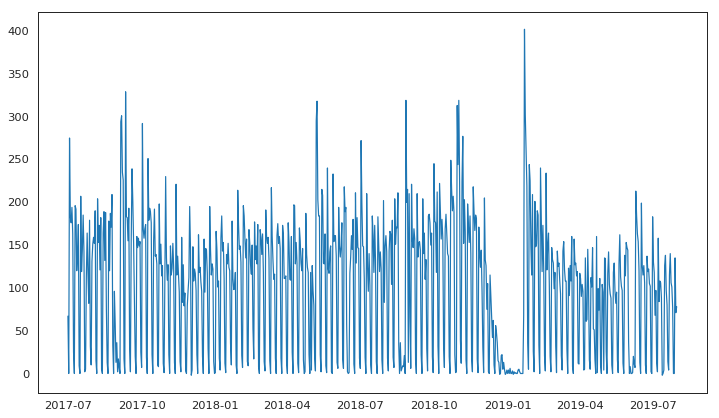

In [0]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

df['ma9'] = df.Units.rolling(window=9).mean()
rolling_mean2 = df.Units.rolling(window=50).mean()
plt.plot(df.date, df.Units, label='AMD')
plt.plot(df.date, rolling_mean, label='AMD 9 Day SMA', color='orange')
plt.plot(df.date, rolling_mean2, label='AMD 50 Day SMA', color='magenta')
plt.legend(loc='upper left')
plt.show()



In [0]:
df['loess_5'] = pd.DataFrame(lowess(df.Units, np.arange(len(df.Units)), frac=0.03)[:, 1], index=df.index, columns=['Units'])

In [0]:
df.head(20)

,date,Units,IsGunuKatsayi,Year,Quarter,Month,Day,weekday,ma9,loess_5
0,2017-07-01,67,nan,2017,3,7,Weekend,0,nan,136.5964
1,2017-07-02,0,nan,2017,3,7,Weekend,0,nan,136.7254
2,2017-07-03,275,nan,2017,3,7,Weekday,1,nan,136.6457
3,2017-07-04,183,nan,2017,3,7,Weekday,1,nan,136.4926
4,2017-07-05,176,nan,2017,3,7,Weekday,1,nan,136.3673
5,2017-07-06,194,nan,2017,3,7,Weekday,1,nan,136.3238
6,2017-07-07,163,nan,2017,3,7,Weekday,1,nan,136.3608
7,2017-07-08,25,nan,2017,3,7,Weekend,0,nan,136.3805
8,2017-07-09,0,nan,2017,3,7,Weekend,0,120.3333,136.1480
9,2017-07-10,196,nan,2017,3,7,Weekday,1,134.6667,135.2445


In [0]:
dataset = df.ma9[8:761].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [0]:
from keras import optimizers
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.05))
model.add(LSTM(50,return_sequences = True))
model.add(Dropout(0.05))
model.add(LSTM(50,return_sequences = True))
model.add(Dropout(0.05))
model.add(LSTM(50))
model.add(Dropout(0.05))
model.add(Dense(1))
Adam=keras.optimizers.Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer='Adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size= 32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience= 10)], verbose=1, shuffle=False)
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 571 samples, validate on 120 samples
Epoch 1/100





571/571 [==============================] - 4s 6ms/step - loss: 0.2615 - val_loss: 0.0867
Epoch 2/100
571/571 [==============================] - 0s 274us/step - loss: 0.1049 - val_loss: 0.0297
Epoch 3/100
571/571 [==============================] - 0s 296us/step - loss: 0.0300 - val_loss: 0.0081
Epoch 4/100
571/571 [==============================] - 0s 276us/step - loss: 0.0239 - val_loss: 0.0158
Epoch 5/100
571/571 [==============================] - 0s 311us/step - loss: 0.0219 - val_loss: 0.0118
Epoch 6/100
571/571 [==============================] - 0s 275us/step - loss: 0.0207 - val_loss: 0.0120
Epoch 7/100
571/571 [==============================] - 0s 398us/step - loss: 0.0201 - val_loss: 0.0120
Epoch 8/100
5

In [0]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))



Train Mean Absolute Error: 6.922674832566711
Train Root Mean Squared Error: 9.68307002157949
Test Mean Absolute Error: 6.646861399139282
Test Root Mean Squared Error: 8.835079168861345


In [0]:
df['Units'].mean()

101.6688567674113

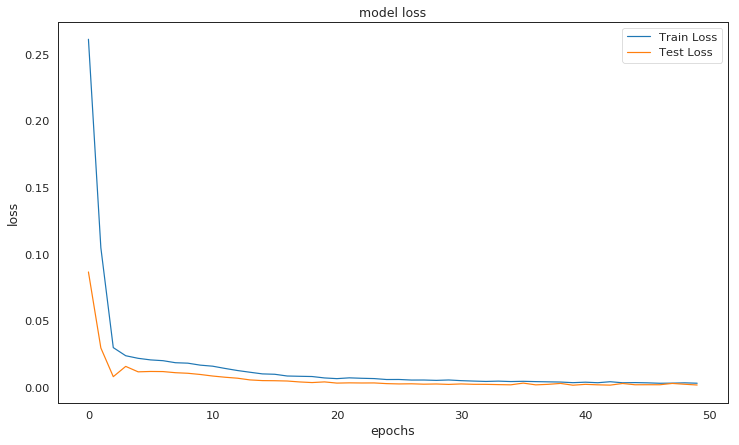

In [0]:
plt.figure(figsize=(12,7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

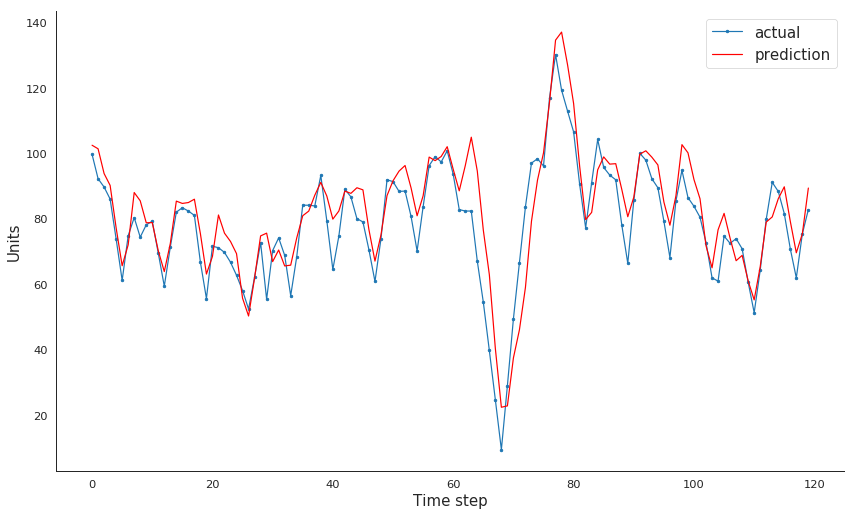

In [0]:
aa=[x for x in range(120)]
plt.figure(figsize=(12,7))
plt.plot(aa, Y_test[0][:120], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:120], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Units', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();